In [1]:
import pandas
data = pandas.read_csv("benchmark_lddt.csv")
data.head()

,Unnamed: 0,cathsm_coverage,cathsm_oligo_lddt,cathsm_qmean4,cathsm_sid,cathsm_sim,cathsm_single_chain_lddt,cathsm_template,cathsm_weighted_lddt,hit,...,sm_qmean4,sm_qmeandisco,sm_rank,sm_sid,sm_sim,sm_single_chain_lddt,sm_template,sm_weighted_lddt,target,target_length
0,0,1.000000,0.813056,-1.08,50.49,0.46,0.813056,4ptx.2.A,0.813056,hit1,...,-2.47,0.790734,1,50.69,0.45,0.823526,5idi.1.A,0.823526,20180804_00000006_1,455
1,1,1.000000,0.693439,-3.02,34.59,0.38,0.693439,1myr.1.A,0.693439,hit3,...,-2.47,0.790711,1,50.69,0.45,0.822760,5idi.1.A,0.822760,20180804_00000006_1,455
2,2,1.000000,0.637661,-4.83,28.46,0.34,0.637661,4ha4.1.A,0.637661,hit2,...,-2.47,0.791037,1,50.69,0.45,0.824045,5idi.1.A,0.824045,20180804_00000006_1,455
3,3,0.971831,0.673953,-1.31,27.82,0.35,0.673953,1ych.2.B,0.673953,hit1,...,-3.83,0.696320,1,28.97,0.35,0.696405,2ark.1.A,0.174101,20180804_00000357_1,149
4,4,0.990991,0.541722,-4.06,36.26,0.37,0.541722,5nul.1.A,0.541722,hit2,...,-3.83,0.699347,1,28.97,0.35,0.721013,2ark.1.A,0.180253,20180804_00000357_1,149


In [2]:
data.columns.values

array(['Unnamed: 0', 'cathsm_coverage', 'cathsm_oligo_lddt',
       'cathsm_qmean4', 'cathsm_sid', 'cathsm_sim',
       'cathsm_single_chain_lddt', 'cathsm_template',
       'cathsm_weighted_lddt', 'hit', 'hit_from', 'hit_rank', 'hit_to',
       'sm_coverage', 'sm_oligo_lddt', 'sm_qmean4', 'sm_qmeandisco',
       'sm_rank', 'sm_sid', 'sm_sim', 'sm_single_chain_lddt',
       'sm_template', 'sm_weighted_lddt', 'target', 'target_length'],
      dtype=object)

In [3]:
# Where do we see the same template?
# We use the SMTL chain index (Aug 28, 2019 version)
chain_index = pandas.read_table("smtl_chain_index", sep=" ", index_col=False,
                             names=['md5', 'chain'])
# Sanity check:
assert not any(chain_index['chain'].duplicated())

# Find MD5 of CATH-SM templates
cathsm_md5 = data[['cathsm_template']].merge(chain_index, 'left', left_on = 'cathsm_template', right_on = 'chain')
# cathsm_md5[cathsm_md5['cathsm_template'] != cathsm_md5['chain']]
cathsm_md5_nona = cathsm_md5.dropna()  # 4igz.1.A and 2ma0.1.A are obsolete
assert all(cathsm_md5_nona['cathsm_template'] == cathsm_md5_nona['chain'])

# Find MD5 of SM templates
sm_md5 = data[['sm_template']].merge(chain_index, 'left', left_on = 'sm_template', right_on = 'chain')
# sm_md5[sm_md5['sm_template'] != sm_md5['chain']]
sm_md5_nona = sm_md5.dropna()  # 6gww.3.B and 4eln.1.A are obsolete
assert all(sm_md5_nona['sm_template'] == sm_md5_nona['chain'])

# Add the MD5 to main dataset
# Assumption: left merge in pandas keeps key order. This is the case in 0.25.1,
# see: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
# "left: use only keys from left frame, similar to a SQL left outer join; preserve key order."
data['same_template_md5'] = cathsm_md5['md5'] == sm_md5['md5']
print("Same MD5: \n" + str(data['same_template_md5'].value_counts()))

# Alternatively we can look whether we have the same PDB ID
data['same_template_pdbid'] = data['cathsm_template'].str.slice(0, 4) == data['sm_template'].str.slice(0, 4)
print("\nSame PDB ID: \n" + str(data['same_template_pdbid'].value_counts()))

Same MD5: 
False    1170
True       78
Name: same_template_md5, dtype: int64

Same PDB ID: 
False    1189
True       59
Name: same_template_pdbid, dtype: int64


## Descriptive statistics

In [4]:
import matplotlib.pyplot as plt
plt.hist(data['target_length'])
plt.show()

<Figure size 640x480 with 1 Axes>

## Full data set

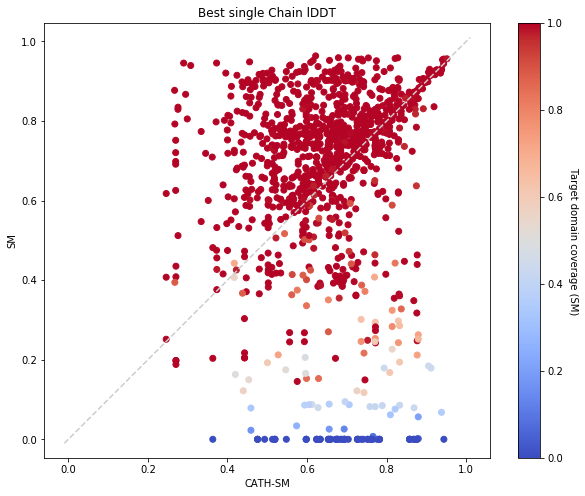

In [5]:
# Single chain lDDT plot - color by SM coverage
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (10, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
plt.scatter(data['cathsm_single_chain_lddt'], data['sm_single_chain_lddt'],
            c=data['sm_coverage'], cmap='coolwarm')
# Axis labels
plt.title("Best single Chain lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup color bar
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
cbar.set_label('Target domain coverage (SM)', rotation=270)
plt.show()

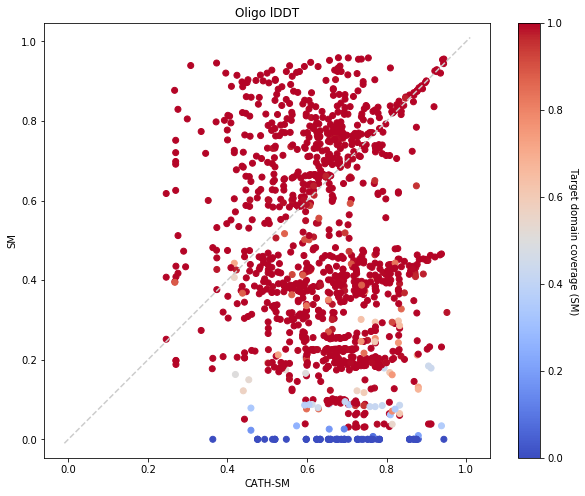

In [6]:
# oligo lDDT plot - color by SM coverage
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (10, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
plt.scatter(data['cathsm_oligo_lddt'], data['sm_oligo_lddt'],
            c=data['sm_coverage'], cmap='coolwarm')
# Axis labels
plt.title("Oligo lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup color bar
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
cbar.set_label('Target domain coverage (SM)', rotation=270)
plt.show()

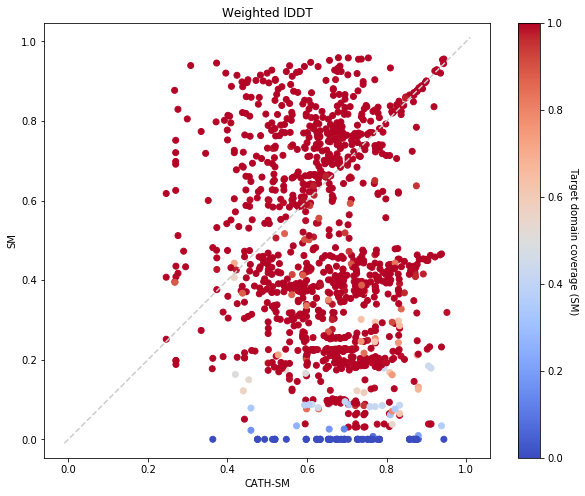

In [7]:
# Weighted lDDT plot - color by SM coverage
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (10, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
plt.scatter(data['cathsm_weighted_lddt'], data['sm_weighted_lddt'],
            c=data['sm_coverage'], cmap='coolwarm')
# Axis labels
plt.title("Weighted lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup color bar
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
cbar.set_label('Target domain coverage (SM)', rotation=270)
plt.show()

Oligo lDDT and Weighted lDDT show different quaternary structures. Not very relevant here. Following plots will all show the best single chain lDDT.

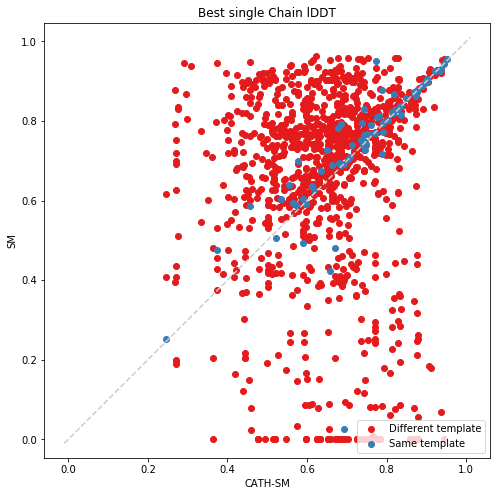

In [8]:
# Single chain lDDT plot - color by template identity
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (8, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
same_template = data[data['same_template_md5']]
diff_template = data[data['same_template_md5'] == False]
plt.scatter(diff_template['cathsm_single_chain_lddt'], 
            diff_template['sm_single_chain_lddt'], 
            c=np.array([plt.cm.Set1(0)]), label="Different template")
plt.scatter(same_template['cathsm_single_chain_lddt'], 
            same_template['sm_single_chain_lddt'], 
            c=np.array([plt.cm.Set1(1)]), label="Same template")

# Axis labels
plt.title("Best single Chain lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup legend
plt.legend(loc='lower right')
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
plt.show()

## First hit

Look only at the first-ranking funfams hit and first SWISS-MODEL (global QMEAN4)

In [9]:
first_hit = data[(data['hit_rank'] == 1) & (data['sm_rank'] == 1)]
first_hit.head()

,Unnamed: 0,cathsm_coverage,cathsm_oligo_lddt,cathsm_qmean4,cathsm_sid,cathsm_sim,cathsm_single_chain_lddt,cathsm_template,cathsm_weighted_lddt,hit,...,sm_rank,sm_sid,sm_sim,sm_single_chain_lddt,sm_template,sm_weighted_lddt,target,target_length,same_template_md5,same_template_pdbid
0,0,1.000000,0.813056,-1.08,50.49,0.46,0.813056,4ptx.2.A,0.813056,hit1,...,1,50.69,0.45,0.823526,5idi.1.A,0.823526,20180804_00000006_1,455,False,False
3,3,0.971831,0.673953,-1.31,27.82,0.35,0.673953,1ych.2.B,0.673953,hit1,...,1,28.97,0.35,0.696405,2ark.1.A,0.174101,20180804_00000357_1,149,False,False
5,5,0.936709,0.722493,-1.28,47.96,0.43,0.722493,1j32.1.A,0.722493,hit2,...,1,43.12,0.41,0.769298,1bkg.1.A,0.384649,20180804_00000360_1,475,False,False
16,16,1.000000,0.657385,-1.29,30.23,0.33,0.657385,3iq2.2.A,0.657385,hit8,...,1,71.43,0.51,0.750194,5xdz.1.A,0.750194,20180804_00000364_1,125,False,False
22,22,1.000000,0.752211,-0.16,45.74,0.42,0.752211,3eif.1.A,0.752211,hit1,...,1,35.80,0.38,0.766653,3eif.1.A,0.766653,20180804_00000377_1,1647,True,True


In [10]:
# Number of models built
print(data.shape[0])
print(first_hit.shape[0])

1248
203


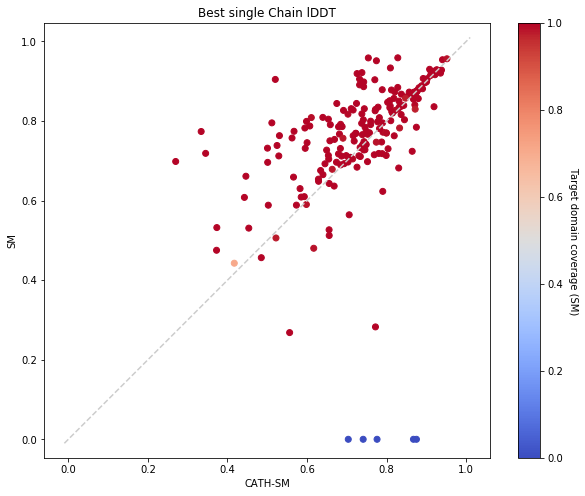

In [11]:
# Single chain lDDT plot
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (10, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
plt.scatter(first_hit['cathsm_single_chain_lddt'], first_hit['sm_single_chain_lddt'],
            c=first_hit['sm_coverage'], cmap='coolwarm')
# Axis labels
plt.title("Best single Chain lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup color bar
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
cbar.set_label('Target domain coverage (SM)', rotation=270)
plt.show()

## Resolved hits

Look at the resolved hits - can have several models per target sequence

In [12]:
# Import the resolved hits data
resolvedhits = pandas.read_table("cameo_models.besthits.crh", sep=" ", comment="#", index_col=False,
                             names=['target', 'hit', 'normalised_qmean4', 'query_range', 'resolved_range'])
resolvedhits.head()

,target,hit,normalised_qmean4,query_range,resolved_range
0,20180804_00000006_1,hit1,98.92,18-453,18-453
1,20180804_00000357_1,hit1,98.69,3-144,3-144
2,20180804_00000360_1,hit2,98.72,116-352,116-352
3,20180804_00000364_1,hit8,98.71,34-119,34-119
4,20180804_00000377_1,hit3,98.37,481-549,481-549


In [13]:
print(resolvedhits.shape)

(247, 5)


### First SM model - QMEAN4

In [14]:
# Look at the best hits - ie we may have multiple domains for a target
# Still look only at the first SWISS-MODEL based on QMEAN4
resolvedhits_data = resolvedhits.merge(data, on=['target', 'hit'], how='inner')
resolvedhits_first_sm = resolvedhits_data[resolvedhits_data['sm_rank'] == 1]
resolvedhits_first_sm.head()

,target,hit,normalised_qmean4,query_range,resolved_range,Unnamed: 0,cathsm_coverage,cathsm_oligo_lddt,cathsm_qmean4,cathsm_sid,...,sm_qmeandisco,sm_rank,sm_sid,sm_sim,sm_single_chain_lddt,sm_template,sm_weighted_lddt,target_length,same_template_md5,same_template_pdbid
0,20180804_00000006_1,hit1,98.92,18-453,18-453,0,1.000000,0.813056,-1.08,50.49,...,0.790734,1,50.69,0.45,0.823526,5idi.1.A,0.823526,455,False,False
1,20180804_00000357_1,hit1,98.69,3-144,3-144,3,0.971831,0.673953,-1.31,27.82,...,0.696320,1,28.97,0.35,0.696405,2ark.1.A,0.174101,149,False,False
2,20180804_00000360_1,hit2,98.72,116-352,116-352,5,0.936709,0.722493,-1.28,47.96,...,0.813228,1,43.12,0.41,0.769298,1bkg.1.A,0.384649,475,False,False
3,20180804_00000364_1,hit8,98.71,34-119,34-119,16,1.000000,0.657385,-1.29,30.23,...,0.812442,1,71.43,0.51,0.750194,5xdz.1.A,0.750194,125,False,False
4,20180804_00000377_1,hit3,98.37,481-549,481-549,27,0.983051,0.442923,-1.63,34.33,...,0.734783,1,35.80,0.38,0.458881,3eif.1.A,0.458881,1647,False,False


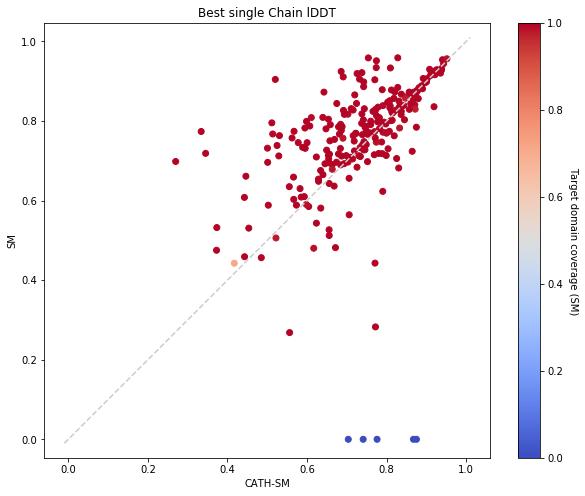

In [15]:
# Single chain lDDT plot
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (10, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
plt.scatter(resolvedhits_first_sm['cathsm_single_chain_lddt'], resolvedhits_first_sm['sm_single_chain_lddt'],
            c=resolvedhits_first_sm['sm_coverage'], cmap='coolwarm')
# Axis labels
plt.title("Best single Chain lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup color bar
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
cbar.set_label('Target domain coverage (SM)', rotation=270)
plt.show()

### Best SM model - lDDT

Still resolved hits but select SWISS-MODEL model based on lDDT

In [16]:
resolvedhits_best_sm = resolvedhits_data \
    .sort_values('sm_single_chain_lddt', ascending=False) \
    .drop_duplicates(['target','hit'])

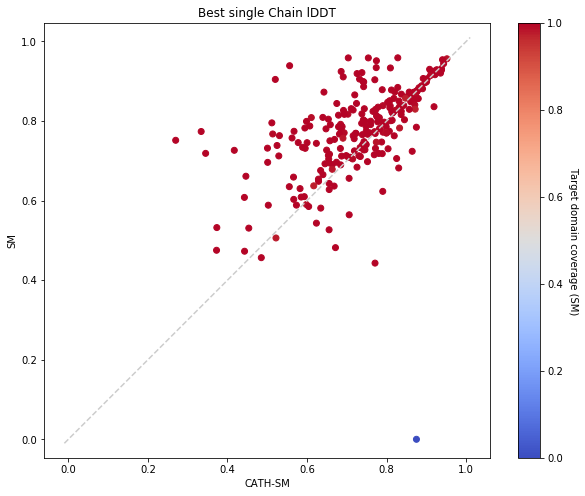

In [17]:
# Single chain lDDT plot
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (10, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
plt.scatter(resolvedhits_best_sm['cathsm_single_chain_lddt'], resolvedhits_best_sm['sm_single_chain_lddt'],
            c=resolvedhits_best_sm['sm_coverage'], cmap='coolwarm')
# Axis labels
plt.title("Best single Chain lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup color bar
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
cbar.set_label('Target domain coverage (SM)', rotation=270)
plt.show()

In [18]:
# Now we're left with only one outlier on coverage...
resolvedhits_best_sm = resolvedhits_best_sm.assign(sm_cathsm_diff=resolvedhits_best_sm['sm_single_chain_lddt'] - resolvedhits_best_sm['cathsm_single_chain_lddt'])
resolvedhits_best_sm.sort_values('sm_cathsm_diff').head()

,target,hit,normalised_qmean4,query_range,resolved_range,Unnamed: 0,cathsm_coverage,cathsm_oligo_lddt,cathsm_qmean4,cathsm_sid,...,sm_rank,sm_sid,sm_sim,sm_single_chain_lddt,sm_template,sm_weighted_lddt,target_length,same_template_md5,same_template_pdbid,sm_cathsm_diff
406,20181222_00000059_1,hit1,100.38,764-924,764-924,1102,1.000000,0.874928,0.38,98.14,...,3,15.25,0.28,0.000000,4zln.1.A,0.000000,943,False,False,-0.874928
156,20180922_00000066_1,hit4,96.23,868-981,868-981,527,0.989796,0.770813,-3.77,35.51,...,1,26.43,0.33,0.442808,2alw.1.A,0.442808,981,False,False,-0.328005
397,20181222_00000029_1,hit2,95.41,251-456,251-456,1087,1.000000,0.671407,-4.59,28.95,...,1,37.66,0.39,0.481716,3eb7.1.A,0.481716,609,True,True,-0.189690
155,20180922_00000066_1,hit2,97.92,571-835,571-835,525,1.000000,0.790257,-2.08,46.48,...,1,26.43,0.33,0.623139,2alw.1.A,0.623139,981,False,False,-0.167118
428,20181229_00000062_1,hit2,100.52,1-109,1-109,1147,1.000000,0.830310,0.52,41.28,...,1,51.82,0.45,0.681892,3vbb.1.A,0.340946,456,False,False,-0.148417


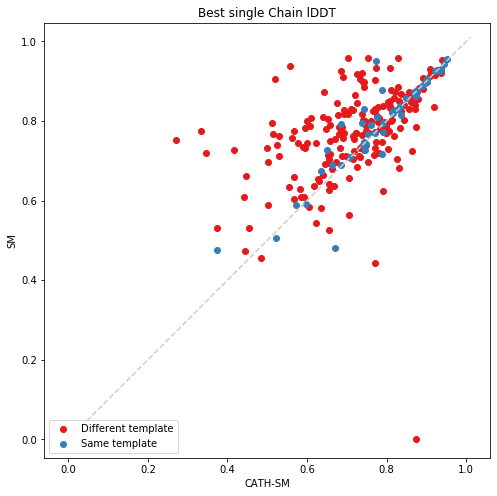

In [19]:
# Single chain lDDT plot - color by template identity
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (8, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
same_template = resolvedhits_best_sm[resolvedhits_best_sm['same_template_md5']]
#same_template = same_template[same_template['target'] == '20181103_00000042_1']
diff_template = resolvedhits_best_sm[resolvedhits_best_sm['same_template_md5'] == False]
#diff_template = diff_template[diff_template['target'] == '20181103_00000042_1']
plt.scatter(diff_template['cathsm_single_chain_lddt'], 
            diff_template['sm_single_chain_lddt'], 
            c=np.array([plt.cm.Set1(0)]), label="Different template")
plt.scatter(same_template['cathsm_single_chain_lddt'], 
            same_template['sm_single_chain_lddt'], 
            c=np.array([plt.cm.Set1(1)]), label="Same template")

# Axis labels
plt.title("Best single Chain lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup legend
plt.legend(loc='lower left')
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
plt.show()

In [20]:
# Look at points in the top left - better in SM, bad in CATH-SM
#resolvedhits_best_sm[resolvedhits_best_sm['same_template_md5']].sort_values('sm_cathsm_diff').tail()
resolvedhits_best_sm.sort_values('sm_cathsm_diff').tail(n=10)

,target,hit,normalised_qmean4,query_range,resolved_range,Unnamed: 0,cathsm_coverage,cathsm_oligo_lddt,cathsm_qmean4,cathsm_sid,...,sm_rank,sm_sid,sm_sim,sm_single_chain_lddt,sm_template,sm_weighted_lddt,target_length,same_template_md5,same_template_pdbid,sm_cathsm_diff
340,20181201_00000066_1,hit7,98.63,699-870,699-870,990,0.982558,0.703588,-1.37,46.84,...,2,100.00,0.61,0.958641,5bvk.1.A,0.958641,876,False,False,0.255053
220,20181020_00000031_1,hit3,97.52,75-165,75-165,678,0.989011,0.511489,-2.48,33.33,...,1,62.37,0.48,0.795330,3t1v.1.A,0.795330,203,False,False,0.283841
85,20180901_00000023_2,hit2,97.13,51-94,51-94,346,0.975610,0.417097,-2.87,48.72,...,3,19.12,0.31,0.726333,2w6d.1.B,0.726333,614,False,False,0.309236
316,20181124_00000044_1,hit3,93.22,9-248,9-248,951,1.000000,0.345074,-6.78,32.54,...,1,34.41,0.37,0.718664,4lk4.1.A,0.718664,506,False,False,0.373591
167,20180929_00000076_1,hit4,98.06,112-245,112-245,545,1.000000,0.556177,-1.94,25.00,...,3,100.00,0.62,0.938984,6bxf.1.A,0.938984,625,False,False,0.382807
243,20181027_00000052_1,hit2,96.35,329-616,329-616,782,0.996479,0.520186,-3.65,29.02,...,1,55.09,0.45,0.904523,5dvy.1.A,0.904523,666,False,False,0.384337
335,20181201_00000065_2,hit1,95.41,2-84,2-84,987,1.000000,0.333855,-4.59,29.85,...,1,80.00,0.52,0.773624,2rb8.1.A,0.773624,87,False,False,0.439768
146,20180922_00000047_1,hit1,94.03,144-255,144-255,514,1.000000,0.269790,-5.97,39.64,...,2,18.52,0.28,0.751523,6eou.1.A,0.751523,320,False,False,0.481734
68,20180818_00000057_1,hit15,98.98,438-535,438-535,255,NaN,NaN,-1.02,35.79,...,1,50.74,0.45,NaN,5dv9.1.A,NaN,546,False,False,NaN
337,20181201_00000066_1,hit3,98.31,22-189,22-189,991,NaN,NaN,-1.69,57.14,...,1,100.00,0.62,NaN,4ag4.1.A,NaN,876,False,False,NaN


In [21]:
resolvedhits_best_sm['same_template_md5'].value_counts()

False    196
True      51
Name: same_template_md5, dtype: int64

In [22]:
# Look at the points in the bottom right - high lDDT in CATH-SM models, low in SM
# Ignore domains that SM didn't cover for now.
resolvedhits_best_sm = resolvedhits_best_sm.assign(sc_lddt_diff=pandas.Series(resolvedhits_best_sm['cathsm_single_chain_lddt'] - resolvedhits_best_sm['sm_single_chain_lddt']).values)
resolvedhits_best_sm.sort_values('sc_lddt_diff', ascending=False).head(n=10)

,target,hit,normalised_qmean4,query_range,resolved_range,Unnamed: 0,cathsm_coverage,cathsm_oligo_lddt,cathsm_qmean4,cathsm_sid,...,sm_sid,sm_sim,sm_single_chain_lddt,sm_template,sm_weighted_lddt,target_length,same_template_md5,same_template_pdbid,sm_cathsm_diff,sc_lddt_diff
406,20181222_00000059_1,hit1,100.38,764-924,764-924,1102,1.000000,0.874928,0.38,98.14,...,15.25,0.28,0.000000,4zln.1.A,0.000000,943,False,False,-0.874928,0.874928
156,20180922_00000066_1,hit4,96.23,868-981,868-981,527,0.989796,0.770813,-3.77,35.51,...,26.43,0.33,0.442808,2alw.1.A,0.442808,981,False,False,-0.328005,0.328005
397,20181222_00000029_1,hit2,95.41,251-456,251-456,1087,1.000000,0.671407,-4.59,28.95,...,37.66,0.39,0.481716,3eb7.1.A,0.481716,609,True,True,-0.189690,0.189690
155,20180922_00000066_1,hit2,97.92,571-835,571-835,525,1.000000,0.790257,-2.08,46.48,...,26.43,0.33,0.623139,2alw.1.A,0.623139,981,False,False,-0.167118,0.167118
428,20181229_00000062_1,hit2,100.52,1-109,1-109,1147,1.000000,0.830310,0.52,41.28,...,51.82,0.45,0.681892,3vbb.1.A,0.340946,456,False,False,-0.148417,0.148417
174,20181006_00000000_1,hit2,97.77,5-75,5-75,558,1.000000,0.705899,-2.23,35.71,...,42.47,0.40,0.564264,1xs3.1.A,0.564264,75,False,False,-0.141636,0.141636
164,20180929_00000058_1,hit1,98.77,1-70,1-70,542,0.957143,0.864253,-1.23,64.29,...,66.30,0.52,0.723871,2lnc.1.A,0.723871,181,False,False,-0.140382,0.140382
388,20181215_00000148_1,hit1,96.35,26-187,26-187,1072,1.000000,0.655372,-3.65,26.76,...,18.18,0.29,0.526597,3cgx.1.A,0.526597,228,False,False,-0.128775,0.128775
153,20180922_00000066_1,hit1,97.88,14-290,14-290,526,1.000000,0.825136,-2.12,51.27,...,26.43,0.33,0.705665,2alw.1.A,0.705665,981,False,False,-0.119472,0.119472
426,20181229_00000060_1,hit1,100.97,247-349,247-349,1145,1.000000,0.874770,0.97,100.00,...,87.50,0.55,0.784377,6d35.1.A,0.784377,350,False,False,-0.090393,0.090393


In [23]:
# Again with less data
resolvedhits_best_sm[['target', 'hit', 'query_range', 'sc_lddt_diff', 'same_template_md5',
                  'cathsm_single_chain_lddt', 'sm_single_chain_lddt',
                  'cathsm_template', 'sm_template']].sort_values('sc_lddt_diff', ascending=False).head(n=10)


,target,hit,query_range,sc_lddt_diff,same_template_md5,cathsm_single_chain_lddt,sm_single_chain_lddt,cathsm_template,sm_template
406,20181222_00000059_1,hit1,764-924,0.874928,False,0.874928,0.000000,3fa0.1.A,4zln.1.A
156,20180922_00000066_1,hit4,868-981,0.328005,False,0.770813,0.442808,1o7d.1.E,2alw.1.A
397,20181222_00000029_1,hit2,251-456,0.189690,True,0.671407,0.481716,3eb7.3.A,3eb7.1.A
155,20180922_00000066_1,hit2,571-835,0.167118,False,0.790257,0.623139,1o7d.1.D,2alw.1.A
428,20181229_00000062_1,hit2,1-109,0.148417,False,0.830310,0.681892,3qo8.1.A,3vbb.1.A
174,20181006_00000000_1,hit2,5-75,0.141636,False,0.705899,0.564264,2ncl.1.A,1xs3.1.A
164,20180929_00000058_1,hit1,1-70,0.140382,False,0.864253,0.723871,2iph.1.B,2lnc.1.A
388,20181215_00000148_1,hit1,26-187,0.128775,False,0.655372,0.526597,2i5e.1.B,3cgx.1.A
153,20180922_00000066_1,hit1,14-290,0.119472,False,0.825136,0.705665,1o7d.1.A,2alw.1.A
426,20181229_00000060_1,hit1,247-349,0.090393,False,0.874770,0.784377,4n6h.1.A,6d35.1.A


In [24]:
# How is the coverage for CATH-SM model?
# Expectation: 100%.
first_hit.sort_values('cathsm_coverage', ascending=True).head()
# Actually: Some parts aren't modeled, typically less than 10%

,Unnamed: 0,cathsm_coverage,cathsm_oligo_lddt,cathsm_qmean4,cathsm_sid,cathsm_sim,cathsm_single_chain_lddt,cathsm_template,cathsm_weighted_lddt,hit,...,sm_rank,sm_sid,sm_sim,sm_single_chain_lddt,sm_template,sm_weighted_lddt,target,target_length,same_template_md5,same_template_pdbid
566,566,0.890323,0.732052,-0.08,54.74,0.47,0.732052,3a2v.1.A,0.732052,hit1,...,1,57.49,0.47,0.890858,6gww.3.B,0.445429,20181006_00000014_1,223,False,False
846,846,0.914894,0.774323,0.45,80.23,0.54,0.774323,4r1n.2.B,0.774323,hit2,...,1,81.21,0.54,0.951413,4r1n.1.A,0.475706,20181103_00000042_1,302,True,True
68,68,0.934066,0.745739,0.31,49.06,0.44,0.745739,3lgv.3.C,0.745739,hit3,...,1,37.74,0.38,0.784342,4ynn.1.A,0.065362,20180811_00000008_1,465,False,False
5,5,0.936709,0.722493,-1.28,47.96,0.43,0.722493,1j32.1.A,0.722493,hit2,...,1,43.12,0.41,0.769298,1bkg.1.A,0.384649,20180804_00000360_1,475,False,False
815,815,0.937239,0.738993,-1.93,35.43,0.38,0.738993,3t32.1.B,0.738993,hit1,...,1,28.19,0.35,0.765642,3l8a.1.A,0.382821,20181103_00000026_1,389,False,False


### Top SM model - avg QMEANDisCo on domain

In [25]:
# Look at the best hits - but now take the top SWISS-MODEL we had based QMEANDisCo
# over the query range (target domain)
resolvedhits_top_sm = resolvedhits_data \
    .sort_values('sm_qmeandisco', ascending=False) \
    .drop_duplicates(['target','hit'])

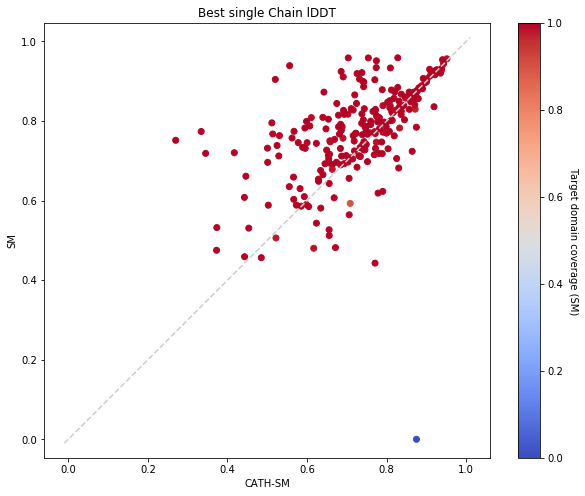

In [26]:
# Single chain lDDT plot
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (10, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
plt.scatter(resolvedhits_top_sm['cathsm_single_chain_lddt'], resolvedhits_top_sm['sm_single_chain_lddt'],
            c=resolvedhits_top_sm['sm_coverage'], cmap='coolwarm')
# Axis labels
plt.title("Best single Chain lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup color bar
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
cbar.set_label('Target domain coverage (SM)', rotation=270)
plt.show()

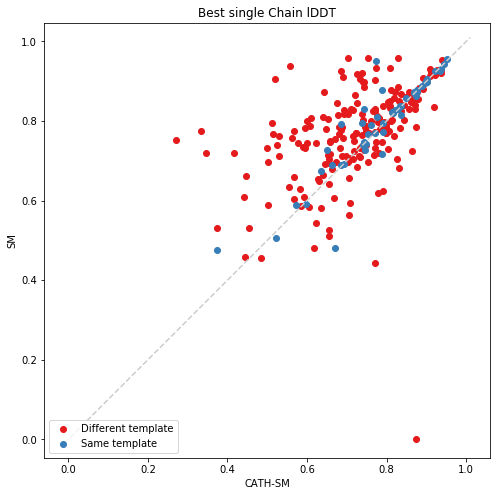

In [27]:
# Single chain lDDT plot - color by template identity
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (8, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
same_template = resolvedhits_top_sm[resolvedhits_top_sm['same_template_md5']]
#same_template = same_template[same_template['target'] == '20181103_00000042_1']
diff_template = resolvedhits_top_sm[resolvedhits_top_sm['same_template_md5'] == False]
#diff_template = diff_template[diff_template['target'] == '20181103_00000042_1']
plt.scatter(diff_template['cathsm_single_chain_lddt'], 
            diff_template['sm_single_chain_lddt'], 
            c=np.array([plt.cm.Set1(0)]), label="Different template")
plt.scatter(same_template['cathsm_single_chain_lddt'], 
            same_template['sm_single_chain_lddt'], 
            c=np.array([plt.cm.Set1(1)]), label="Same template")

# Axis labels
plt.title("Best single Chain lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup legend
plt.legend(loc='lower left')
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
plt.show()

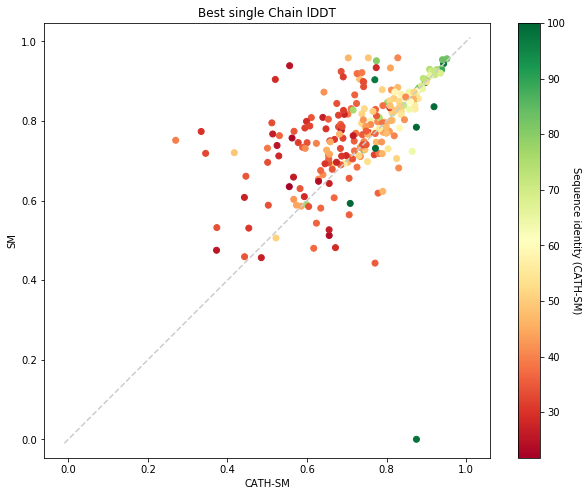

In [45]:
# Single chain lDDT plot
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (10, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
plt.scatter(resolvedhits_top_sm['cathsm_single_chain_lddt'], resolvedhits_top_sm['sm_single_chain_lddt'],
            c=resolvedhits_top_sm['cathsm_sid'], cmap='RdYlGn')
# Axis labels
plt.title("Best single Chain lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup color bar
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
cbar.set_label('Sequence identity (CATH-SM)', rotation=270)
plt.show()

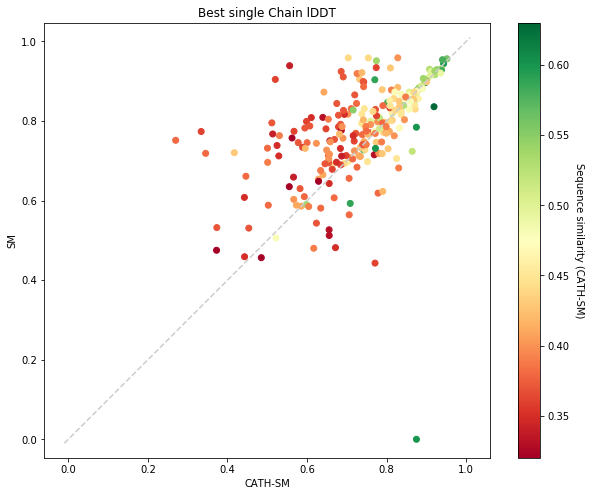

In [48]:
# Single chain lDDT plot
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (10, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
plt.scatter(resolvedhits_top_sm['cathsm_single_chain_lddt'], resolvedhits_top_sm['sm_single_chain_lddt'],
            c=resolvedhits_top_sm['cathsm_sim'], cmap='RdYlGn')
# Axis labels
plt.title("Best single Chain lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup color bar
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
cbar.set_label('Sequence similarity (CATH-SM)', rotation=270)
plt.show()

## Is there some global scale correlation?

In [29]:
# Pearson correlation
resolvedhits_top_sm[['cathsm_single_chain_lddt', 'sm_single_chain_lddt']].dropna().corr()

,cathsm_single_chain_lddt,sm_single_chain_lddt
cathsm_single_chain_lddt,1.000000,0.533825
sm_single_chain_lddt,0.533825,1.000000


In [30]:
# Spearman correlation
resolvedhits_top_sm[['cathsm_single_chain_lddt', 'sm_single_chain_lddt']].dropna().corr('spearman')

,cathsm_single_chain_lddt,sm_single_chain_lddt
cathsm_single_chain_lddt,1.000000,0.647834
sm_single_chain_lddt,0.647834,1.000000


In [31]:
# Average lDDT?
resolvedhits_top_sm[['cathsm_single_chain_lddt', 'sm_single_chain_lddt']].dropna().mean()

cathsm_single_chain_lddt    0.731192
sm_single_chain_lddt        0.772676
dtype: float64

In [32]:
resolvedhits_top_sm[['cathsm_single_chain_lddt', 'sm_single_chain_lddt']].dropna().shape

(245, 2)

In [33]:
resolvedhits_top_sm[['cathsm_single_chain_lddt', 'sm_single_chain_lddt']].dropna().to_csv("selected.csv")

## Best hit 

Does it make a difference if we take the hit with highest lDDT?
We take the hit with the model resulting in the higest lDDT, and then the SM model with the highest lDDT.

In [34]:
besthit_best_sm = data \
    .sort_values(['cathsm_single_chain_lddt', 'sm_single_chain_lddt'], ascending=False) \
    .drop_duplicates(['target'])
besthit_best_sm[['target', 'hit', 'cathsm_single_chain_lddt', 'hit_rank', 'sm_rank', 'sm_single_chain_lddt']].head()

,target,hit,cathsm_single_chain_lddt,hit_rank,sm_rank,sm_single_chain_lddt
1198,20190105_00000109_1,hit1,0.951555,1,1,0.956419
994,20181201_00000066_1,hit4,0.943876,3,2,0.955781
458,20180908_00000110_1,hit2,0.943243,2,1,0.944161
428,20180908_00000004_1,hit1,0.940414,1,1,0.954029
614,20181013_00000002_1,hit1,0.937903,1,1,0.927950


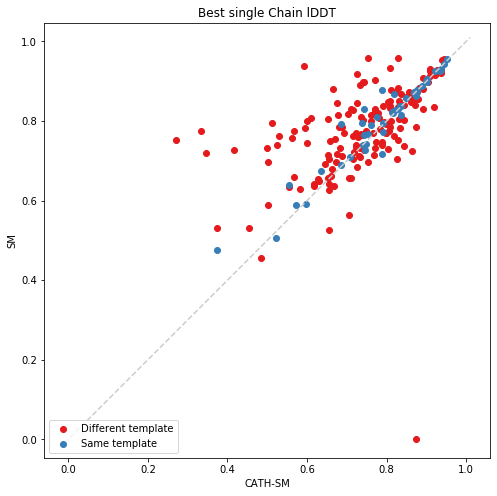

In [35]:
# Single chain lDDT plot - color by template identity
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (8, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
same_template = besthit_best_sm[besthit_best_sm['same_template_md5']]
#same_template = same_template[same_template['target'] == '20181103_00000042_1']
diff_template = besthit_best_sm[besthit_best_sm['same_template_md5'] == False]
#diff_template = diff_template[diff_template['target'] == '20181103_00000042_1']
plt.scatter(diff_template['cathsm_single_chain_lddt'], 
            diff_template['sm_single_chain_lddt'], 
            c=np.array([plt.cm.Set1(0)]), label="Different template")
plt.scatter(same_template['cathsm_single_chain_lddt'], 
            same_template['sm_single_chain_lddt'], 
            c=np.array([plt.cm.Set1(1)]), label="Same template")

# Axis labels
plt.title("Best single Chain lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup legend
plt.legend(loc='lower left')
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
plt.show()

To contrast with the first hit based on QMEAN4 instead of best lDDT:

In [36]:
firsthit_best_sm = data \
    .sort_values(['hit_rank', 'sm_single_chain_lddt'], ascending=[True, False]) \
    .drop_duplicates(['target'])
firsthit_best_sm[['target', 'hit', 'cathsm_single_chain_lddt', 'hit_rank', 'sm_rank', 'sm_single_chain_lddt']].head()

,target,hit,cathsm_single_chain_lddt,hit_rank,sm_rank,sm_single_chain_lddt
1164,20190105_00000048_1,hit1,0.828030,1,1,0.958840
990,20181201_00000066_1,hit7,0.703588,1,2,0.958641
365,20180901_00000048_1,hit1,0.754015,1,1,0.958565
1198,20190105_00000109_1,hit1,0.951555,1,1,0.956419
428,20180908_00000004_1,hit1,0.940414,1,1,0.954029


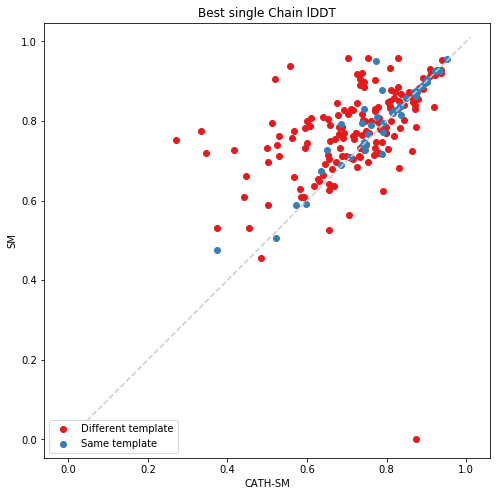

In [37]:
# Single chain lDDT plot - color by template identity
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
# %matplotlib notebook
mpl.rcParams["figure.figsize"] = (8, 8)
# Identity line
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".8")
# Main plot
same_template = firsthit_best_sm[firsthit_best_sm['same_template_md5']]
#same_template = same_template[same_template['target'] == '20181103_00000042_1']
diff_template = firsthit_best_sm[firsthit_best_sm['same_template_md5'] == False]
#diff_template = diff_template[diff_template['target'] == '20181103_00000042_1']
plt.scatter(diff_template['cathsm_single_chain_lddt'], 
            diff_template['sm_single_chain_lddt'], 
            c=np.array([plt.cm.Set1(0)]), label="Different template")
plt.scatter(same_template['cathsm_single_chain_lddt'], 
            same_template['sm_single_chain_lddt'], 
            c=np.array([plt.cm.Set1(1)]), label="Same template")

# Axis labels
plt.title("Best single Chain lDDT")
plt.xlabel("CATH-SM")
plt.ylabel("SM")
# Setup legend
plt.legend(loc='lower left')
cbar.ax.get_yaxis().labelpad = 15
plt.axis('equal')
plt.show()